Separate the initalization into a couple pieces. Probably don't need to activate the environment every time.

In [1]:
using Pkg
Pkg.status()

Status `~/github/CHEM-5555/Numerical Solutions to Differential Equations/Project.toml`
  [5fb14364] OhMyREPL v0.5.28
  [91a5bcdd] Plots v1.40.9
  [295af30f] Revise v3.7.2
  [f2b01f46] Roots v2.2.4
  [3a884ed6] UnPack v1.0.2
  [8dfed614] Test v1.11.0


**Runge-Kutta (RK) integrators for numerical differential equations.**

The objective of this class is to use explicit RK integrators to study the behavior of *nonlinear* differential equations.

In [2]:
using Plots
using UnPack

Begin by importing the home-built ODE library. We're going to extend these methods by developing other explicit integrators based on *explicit Runge Kutta* schemes.

In [3]:
include("JDE_ODE_Base.jl")
using .JDE_ODE_Base #The . is necessary to use the module in the current scope
import .JDE_ODE_Base: step #You must explicitly import the function to write an implementation for it.
import UnPack: @unpack

In [4]:
#The work of writing the integrator falls to the step function. Here's an implementation of Forward
# Euler. The step function takes an ODEProblem, an ODEIntegrator, the current state yₙ, and the current time tₙ.
struct ForwardEuler <: ODEIntegrator end
function step(problem::ODEProblem, ::ForwardEuler, yₙ::Float64, tₙ::Float64)
    @unpack f, h = problem
    return yₙ + h*f(yₙ,tₙ)
end

struct Midpoint <: ODEIntegrator end
function step(problem::ODEProblem, ::Midpoint, yₙ::Float64, tₙ::Float64)
    @unpack f, h = problem
    k₁ = f(yₙ, tₙ)
    k₂ = f(yₙ + (h/2)*k₁, tₙ + h/2)
    return yₙ + h*k₂
end

struct RK2 <: ODEIntegrator end
function step(problem::ODEProblem, ::RK2, yₙ::Float64, tₙ::Float64)
    @unpack f, h = problem
    k₁ = f(yₙ, tₙ)
    k₂ = f(yₙ + h*k₁, tₙ + h)
    return yₙ + h/2*(k₁ + k₂)
end

step (generic function with 3 methods)

Write some functions to make comparisons between different integrators easier.

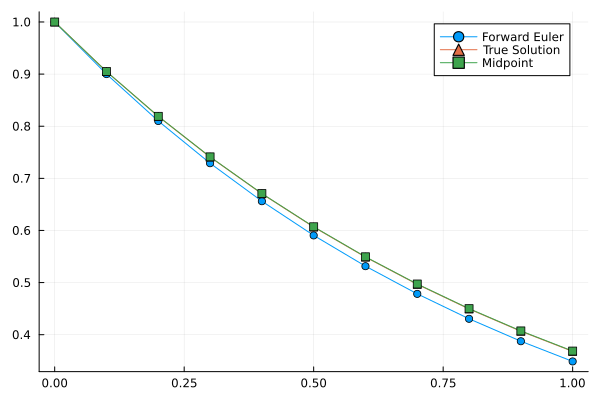

In [5]:

#Compare the accuracy and computational cost of two different integrators using the same problem and the same timestep.
function compare(int1::ODEIntegrator, int2::ODEIntegrator, integrator_name1::String, integrator_name2::String)
    f(y, t) = -y
    y₀ = 1.0
    T = 1.0
    h = 0.1
    problem = ODEProblem(f, y₀, T, h)
    solution1 = solve(problem, int1)
    solution2 = solve(problem, int2)
    plot(solution1.t, solution1.y, label=integrator_name1,marker=:circle)
    plot!(solution1.t, exp.(-solution1.t), label="True Solution",marker=:utriangle)
    plot!(solution2.t, solution2.y, label=integrator_name2,marker=:square)
end

compare(ForwardEuler(), Midpoint(), "Forward Euler", "Midpoint")

In [6]:

#Compare the accuracy of two different integrators using the same problem. 
function compare(int1::ODEIntegrator, int2::ODEIntegrator, integrator_name1::String, integrator_name2::String, problem::ODEProblem)
    solution1 = solve(problem, int1)
    solution2 = solve(problem, int2)
    plot(solution1.t, solution1.y, label=integrator_name1,marker=:circle)
    plot!(solution2.t, solution2.y, label=integrator_name2,marker=:square)
end

#Compare the accuracy of two different integrators using the same problem but different stepsizes.
function compare(int1::ODEIntegrator, int2::ODEIntegrator, integrator_name1::String, integrator_name2::String, h1::Float64, h2::Float64)
    f(y, t) = -y
    y₀ = 1.0
    T = 1.0
    h = 0.1
    problem1 = ODEProblem(f, y₀, T, h1)
    problem2 = ODEProblem(f, y₀, T, h2)
    solution1 = solve(problem, int1)
    solution2 = solve(problem, int2)
    plot(solution1.t, solution1.y, label=integrator_name1,marker=:circle)
    plot!(solution1.t, exp.(-solution1.t), label="True Solution",marker=:utriangle)
    plot!(solution2.t, solution2.y, label=integrator_name2,marker=:square)
    title!(plot_title)
end


function compare_yy(int1::ODEIntegrator, int2::ODEIntegrator, integrator_name1::String, integrator_name2::String, problem::ODEProblem)
    solution1 = solve(problem, int1)
    solution2 = solve(problem, int2)
    p = plot(solution1.y, solution2.y, xlabel=integrator_name1,ylabel=integrator_name2,label="$(integrator_name1) vs $(integrator_name2)",marker=:circle)
    plot!(p,solution1.y,solution1.y,label="Perfect Agreement",color=:black, dashed=true)
    display(p)
end


compare_yy (generic function with 1 method)

Test the Ozone production problem to check the bifurcation transition.

Near bifurcation, the ozone concentration satisfies

\begin{equation}
\frac{dy}{dt} = -y + \beta y^2
\end{equation}

where $y(t) = \frac{[O_3(t)]}{[O_3(0)]}$ and $\beta$ is a ratio of the bimolecular production rate to the unimolecular decomposition rate.

Note the use of the semicolon in the argument list to use keyword arguments (kwargs). This is very useful for avoiding errors. The function has default parameters indicated in its definition as well.

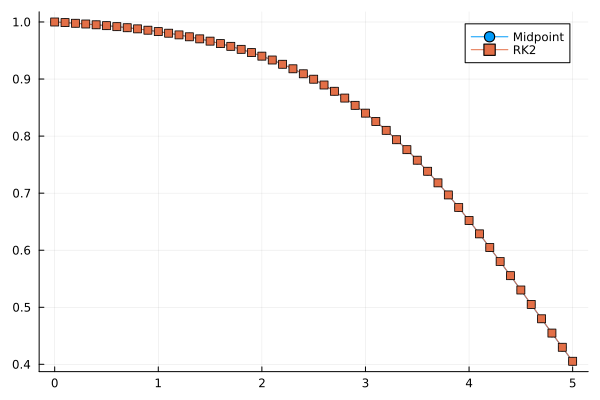

In [7]:
function ozone(β::Float64)
    return (y,t) -> -y + β*y*y
end

#The semicolon syntax enables keyword arguments. The equality sign assigns a default value to the keyword argument.
function Ozone(; β::Float64=1.0, y₀::Float64=1.0, T::Float64=5.0, h::Float64=0.1)
    return ODEProblem(ozone(β), y₀, T, h)
end

compare(Midpoint(), RK2(), "Midpoint", "RK2", Ozone(β = 0.99))

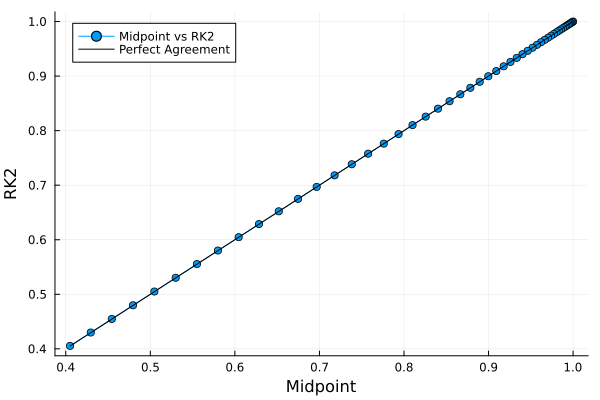

In [8]:
compare_yy(Midpoint(), RK2(), "Midpoint", "RK2", Ozone(β = 0.99))

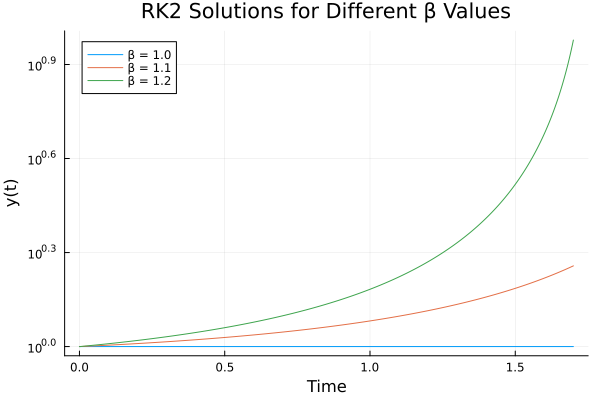

In [9]:
#Play with this to see how the solution changes with different values of β. Be skeptical of the results you get.

β_values = 1.0:0.1:1.2
p = plot(title="RK2 Solutions for Different β Values", xlabel="Time", ylabel="y(t)",yscale=:log10)
for β_ in β_values
    problem = Ozone(β = β_,h=0.001,T=1.7)
    solution = solve(problem, RK2())
    plot!(p, solution.t, solution.y, label="β = $β_",yscale=:log10)
end
display(p)

You should notice that the solution diverges for long times, rather sharply. Is this real, or is this an artififact of the solution method?

We can use the same analysis that we did for local error analysis to analyze the accuracy, at least locally. Replace $y$ with $y + \delta y$ and linearize about $y$.

\begin{equation}
\frac{d\delta y}{dt} = J(y)\delta y,
\end{equation}

with $J(y)$ the *Jacobian* of the problem. In this problem, the Jacobian is easy because the forcing function only depends on one variable, $y$. $J(y) = \frac{\partial f(y,t)}{\partial y}$. The Jacobian is
\begin{equation}
J(y) = 2\beta y - 1.
\end{equation}
As $y$ gets larger, so too does the Jacobian. While you may be able to satisfy *local stability* by sampling fast enough for small $y$ (and small $t$), for $\beta>1$, the gain term grows without bound. This means that you *cannot* sample the function fast enough using a fixed time spacing $h$ for all times. You can only trust the solution for $y$ and $J(y)$ that satisfies $h J(y) \ll 1$.

**Fourth-Order Integrators**
Runge-Kutta 4 is a *4$^{th}$ order accurate integrator that follows, in large part, the logic of RK2. For many peple, RK4 is the star of the show. It's a starting point to solving a differential equation if you don't know any better. More often than not, its solutions are stable and accurate.

RK4 uses two estimates in the middle of the interval to estimate the forcing function. To it, it adds estimates of the forcing function at the ends of the interval and takes a weighted average. You weight the points in the interior of the interval a factor of two higher than the points in the ends of the interval. If you're really paying attention, you'll notice that the weighting coefficients sum to one, as they must for a Runge-Kutta method to be stable.

To prove why this is an optimal estimate of the forcing function in a small interval is beyond the scope of the class, but the curious reader can consult Numerical Recipes.

The RK4 method goes like this:
$$ \begin{aligned} k_1 &= f(y_n, t_n) \\
k_2 &= f(y_n + \frac{h}{2}k_1, t_n + \frac{h}{2}\\ 
k_3 &= f(y_n + \frac{h}{2}k_2, t_n + \frac{h}{2}) \\
k_4 &= f(y_n + hk_3, t_n + h) \\
y_{n+1} &= y_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) 
\end{aligned} $$

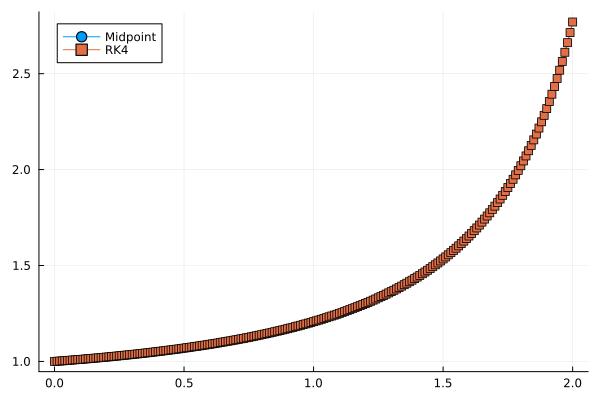

In [10]:
#Write the RK4 method:

struct RK4 <: ODEIntegrator end
function step(problem::ODEProblem, ::RK4, yₙ::Float64, tₙ::Float64)
    @unpack f, h = problem
    k₁ = f(yₙ, tₙ)
    k₂ = f(yₙ + h/2*k₁, tₙ + h/2)
    k₃ = f(yₙ + h/2*k₂, tₙ + h/2)
    k₄ = f(yₙ + h*k₃, tₙ + h)
    return yₙ + h/6*(k₁ + 2k₂ + 2k₃ + k₄)
end

#Ensure that RK2 and RK4 agree with one another for the Ozone problem.
compare(RK2(), RK4(), "Midpoint", "RK4", Ozone(β = 1.1,T=2.0,h=0.01))

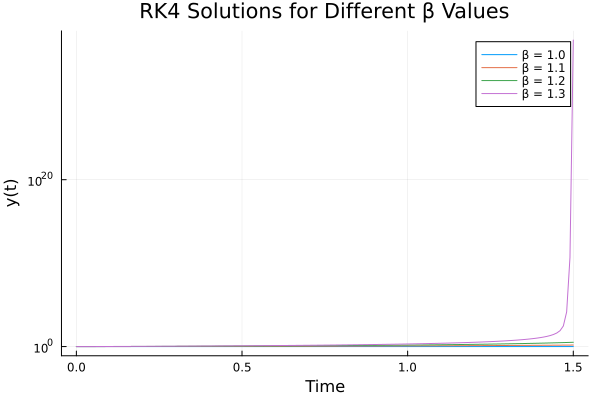

In [16]:
#Now repeat the analysis of the divergence with RK4:

β_values = 1.0:0.1:1.3
p = plot(title="RK4 Solutions for Different β Values", xlabel="Time", ylabel="y(t)",yscale=:log10)
for β_ in β_values
    problem = Ozone(β = β_,h=1e-2,T=1.5)
    solution = solve(problem, RK2())
    plot!(p, solution.t, solution.y, label="β = $β_",yscale=:log10)
end
display(p)

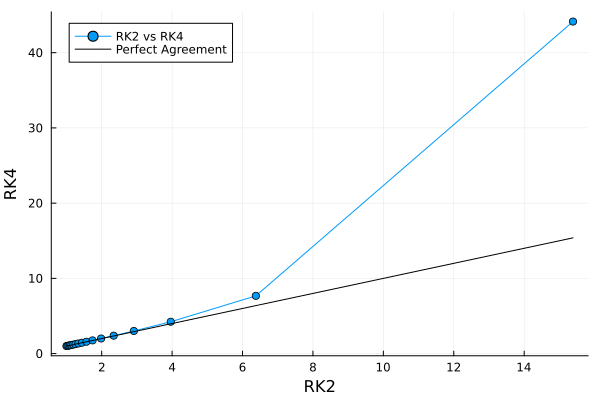

In [23]:
#Adjust some of these parameters for yourself to see where the two integrators
#agree and where they do not.

compare_yy(RK2(), RK4(), "RK2", "RK4", Ozone(β = 1.25,T=1.6,h=0.1))